# CS231a PSET 4 Problem 4: Optical Flow

Use this notebook to run the last portion of problem 1 of PSET 4. Instead of connecting to your Drive, you can just upload using the files tab on the right. In this problem we will use a pre-trained optical flow model to generate optical flow estimates to compare to traditional dense flow methods. **You will not need to modify this notebook drastically**, only be able to load the correct files and run the different sections to generate the correct outputs. It is mostly a tutorial on how to load and use a [FlowNet model](https://ieeexplore.ieee.org/document/7410673).

**Using a GPU**. Make sure to first change your runtime to use a GPU: click Runtime -> Change runtime type -> Hardware Accelerator -> GPU and your Colab instance will automatically be backed by GPU compute.

First, you should upload the files in the `ps4_code/` directory. **You will also need to put the pre-trained** [FlowNet](https://drive.google.com/file/d/1jbWiY1C_nqAUJRYZu7mwzV6CK7ugsa5v/view?usp=sharing) model in that directory as well (`ps4_code/`), by clicking 'Add shortcut to Drive' and moving it to that folder.

Then, run the following:

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the .py files in 'p1/code' needed for this problem
# e.g. 'cs231a/ps4_code':
FOLDERNAME = 'problem_set_4/p4'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive
%cd $FOLDERNAME
%ls .

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/problem_set_4/p4
FlowNet.ipynb  flownets_EPE1.951.pth  p4_data/


**Please check and make sure that the file `flownets_EPE1.951.pth` is visible in this directory.**

## Set up ml4a and enable GPU

First, enable using the GPU (`Runtime` > `Change runtime type`), and then run the following cell to install ml4a and its dependencies.

In [2]:
!pip install --quiet git+https://github.com/krishpop/ml4a
!pip install --quiet imageio==2.4.1
!pip install --quiet -U --no-cache-dir gdown --pre
!pip3 install Pillow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 61.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.9/305.9 KB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Get optical flow between images

First we load two images, which happen to be consecutive frames of a movie. 

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2531328/45929032 bytes (5.5%)4980736/45929032 bytes (10.8%)8019968/45929032 bytes (17.5%)9781248/45929032 bytes (21.3%)12304384/45929032 bytes (26.8%)14819328/45929032 bytes (32.3%)17039360/45929032 bytes (37.1%)19767296/45929032 bytes (43.0%)23322624/45929032 bytes (50.8%)27697152/45929032 bytes (60.3%)31760384/45929032 bytes (69.2%)36020224/45929032 bytes (78.4%)4

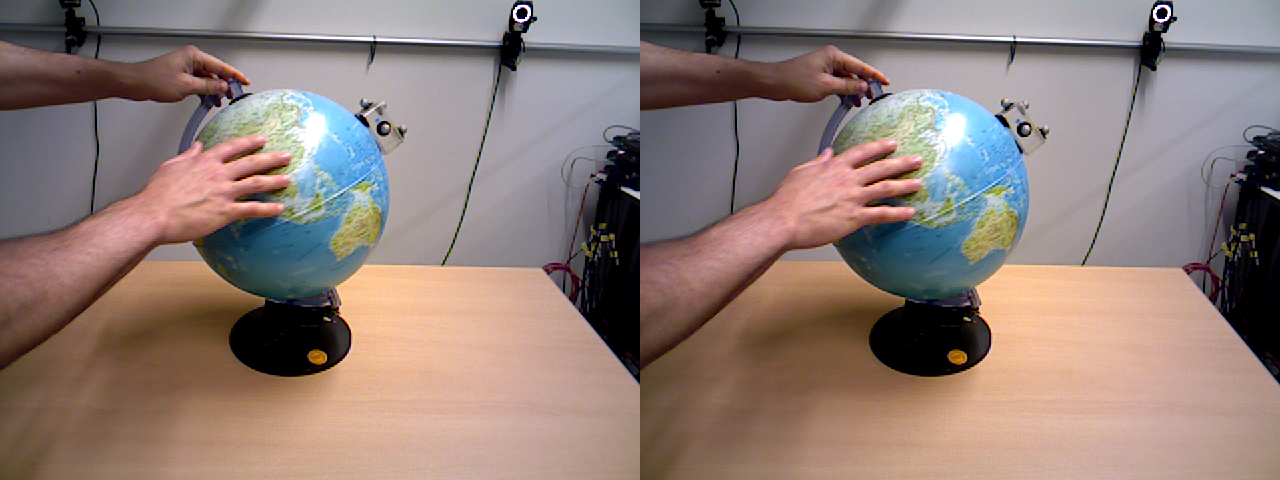

In [3]:
from ml4a import image
from ml4a.canvas import canvas
from PIL import Image

globeimg1 = Image.open('p4_data/globe1/rgb04.png')
globeimg2 = Image.open('p4_data/globe1/rgb06.png')

image.display([globeimg1, globeimg2])

In [4]:
import torch
from ml4a.models import flownet

# The torch model should be saved in `ps4_code/`, see instructions at top for how to download
network_data = torch.load("flownets_EPE1.951.pth")
flownet.device = "cuda"
flownet.model = flownet.models.__dict__[network_data['arch']](network_data).to("cuda")
flownet.model.eval()

  warnings.warn("failed to load custom correlation module"



FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4_1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512,

In [5]:
# get flow from img1 to img2
flow = flownet.run(globeimg1, globeimg2) 

# blurring the flow reduces any high-frequency noise in the raw flowmap
flow = flownet.blur(flow, blur_times=10)

It's easier to visualize the flowmap if we map it to color. Then we can display it.

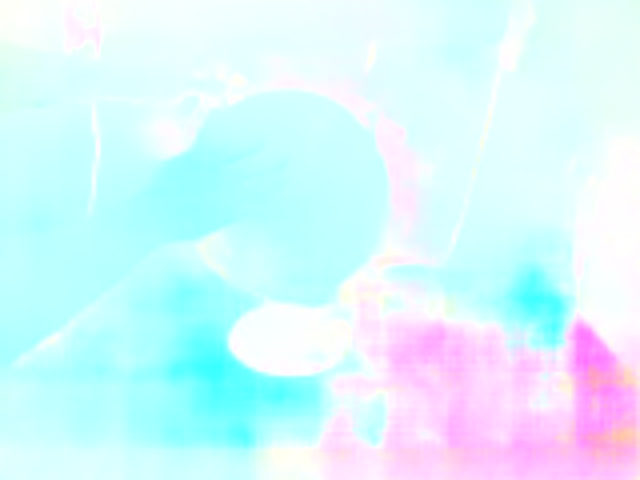

In [6]:
rgb_flow = flownet.run(globeimg1, globeimg2, to_rgb=True) 
image.display(rgb_flow)

One way to see what the optical flow does is to use the flowmap on one of the images to reconstruct the other. We can do that with `canvas.map_image`.

image 2


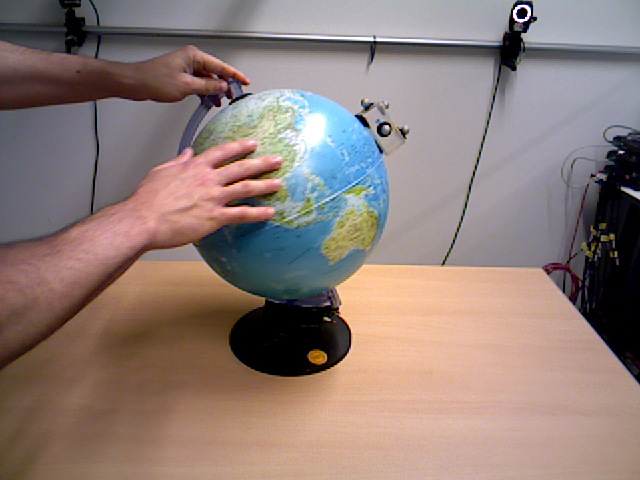

image 2 reconstructed from image 1 + flow


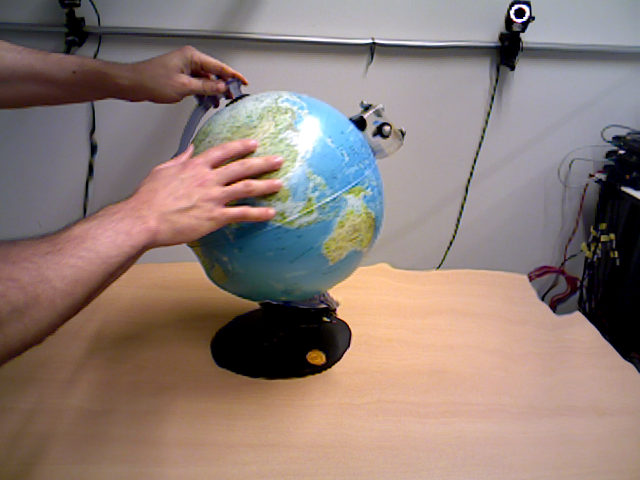

In [7]:
mapping_1to2 = flownet.flow_to_mapping(-flow)
mapping_2to1 = flownet.flow_to_mapping(flow)

globeimg2_reconstructed = canvas.map_image(globeimg1, mapping_1to2)
globeimg1_reconstructed = canvas.map_image(globeimg2, mapping_2to1)

image.display(globeimg2, title="image 2")
image.display(globeimg2_reconstructed, title="image 2 reconstructed from image 1 + flow")

Repeat the steps above for the other two pairs of images

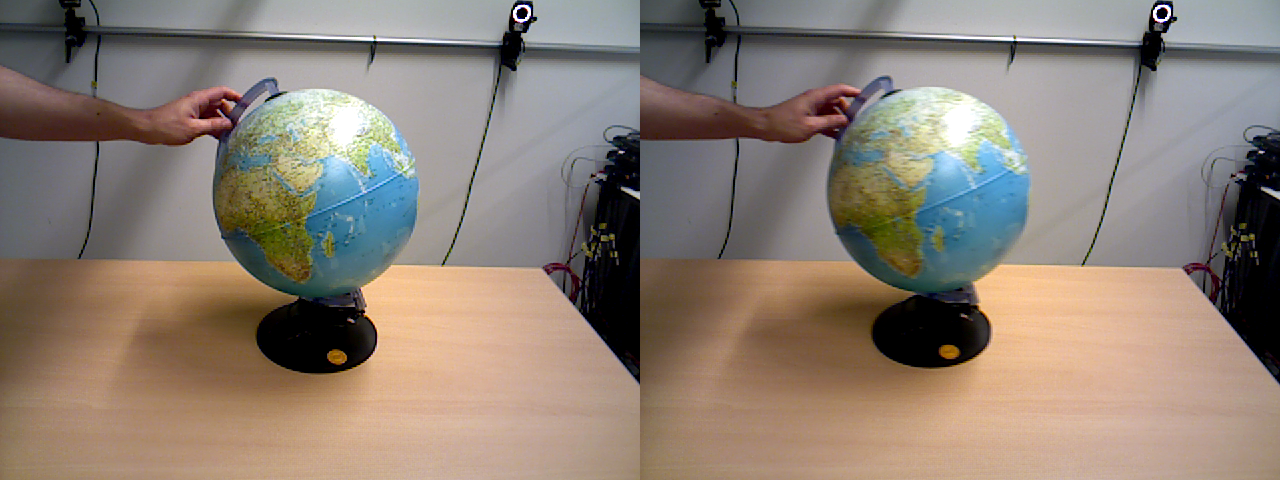

In [8]:
globeimg3 = Image.open('p4_data/globe2/rgb01.png')
globeimg4 = Image.open('p4_data/globe2/rgb02.png')

image.display([globeimg3, globeimg4])

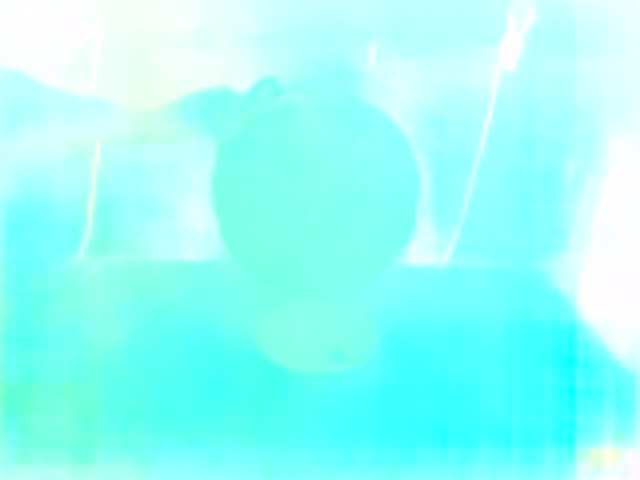

In [9]:
# get flow from img1 to img2
flow = flownet.run(globeimg3, globeimg4) 

# blurring the flow reduces any high-frequency noise in the raw flowmap
flow = flownet.blur(flow, blur_times=2)

rgb_flow = flownet.run(globeimg3, globeimg4, to_rgb=True) 
image.display(rgb_flow)

image 2


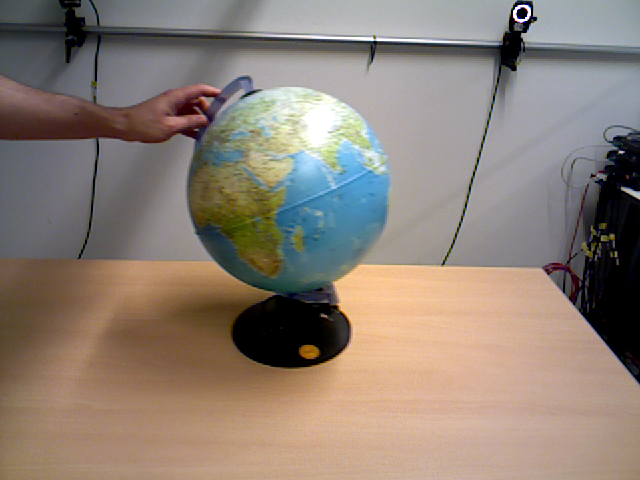

image 2 reconstructed from image 1 + flow


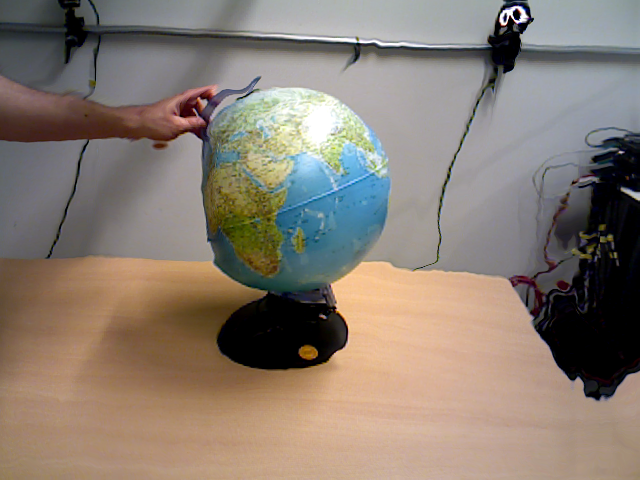

In [10]:
mapping_1to2 = flownet.flow_to_mapping(-flow)
mapping_2to1 = flownet.flow_to_mapping(flow)

globeimg4_reconstructed = canvas.map_image(globeimg3, mapping_1to2)
globeimg3_reconstructed = canvas.map_image(globeimg4, mapping_2to1)

image.display(globeimg4, title="image 2")
image.display(globeimg4_reconstructed, title="image 2 reconstructed from image 1 + flow")

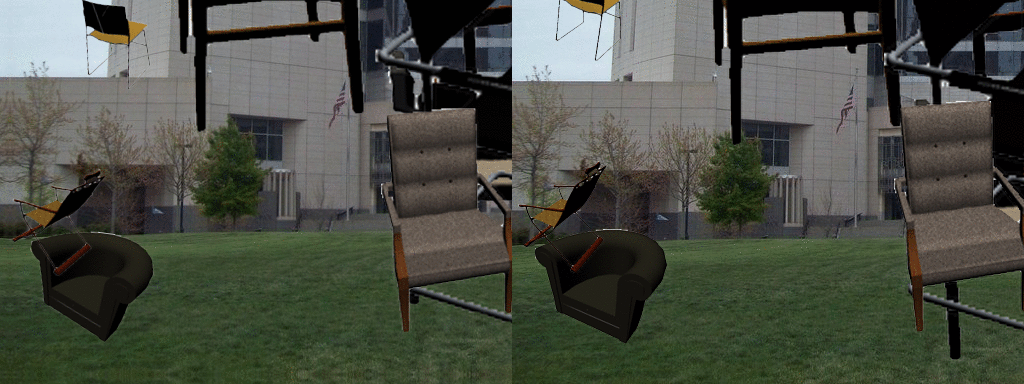

In [11]:
chairimg1 = Image.open('p4_data/chairs/frame_1_chairs.png').convert('RGB')
chairimg2 = Image.open('p4_data/chairs/frame_2_chairs.png').convert('RGB')

image.display([chairimg1, chairimg2])

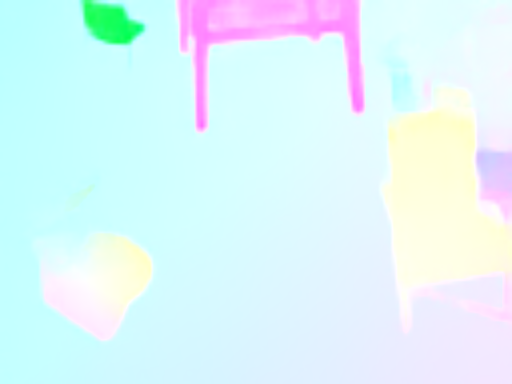

In [12]:
# get flow from img1 to img2
flow = flownet.run(chairimg1, chairimg2) 

# blurring the flow reduces any high-frequency noise in the raw flowmap
flow = flownet.blur(flow, blur_times=10)

rgb_flow = flownet.run(chairimg1, chairimg2, to_rgb=True) 
image.display(rgb_flow)

image 2


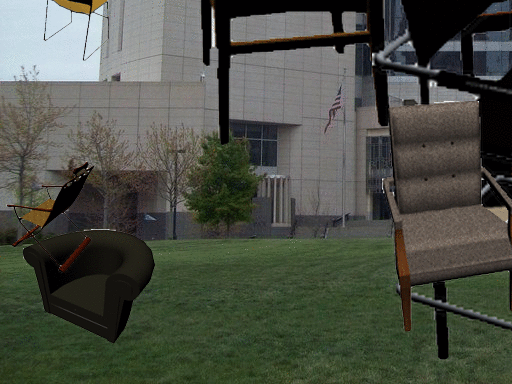

image 2 reconstructed from image 1 + flow


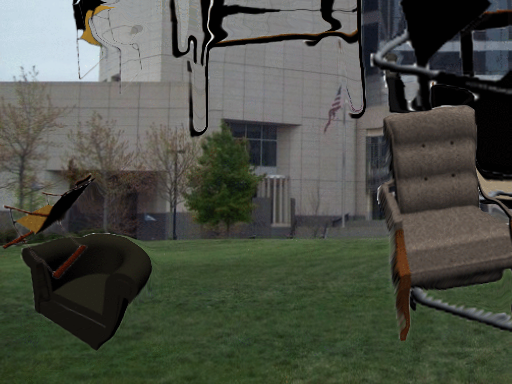

In [13]:
mapping_1to2 = flownet.flow_to_mapping(-flow)
mapping_2to1 = flownet.flow_to_mapping(flow)

chairimg2_reconstructed = canvas.map_image(chairimg1, mapping_1to2)
chairimg1_reconstructed = canvas.map_image(chairimg2, mapping_2to1)

image.display(chairimg2, title="image 2")
image.display(chairimg2_reconstructed, title="image 2 reconstructed from image 1 + flow")


That's it! Just download these images to include in your report, and compare to the results from the previous parts of PS4 Problem 4

Credit: this notebook is dervied from [this one](https://colab.research.google.com/github/ml4a/ml4a/blob/master/examples/models/FlowNetPytorch.ipynb)